In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import ferbo as fb
import numpy as np
from utils import plot_style
from qutip import *
import functools
import matplotlib.pyplot as plt
from scipy import special
from scipy.constants import hbar, e, k, h
from scipy.optimize import fsolve, minimize, basinhopping
from scipy.special import hermite, factorial
from tqdm.notebook import tqdm
import sympy as sp
from joblib import Parallel, delayed
from itertools import product

ModuleNotFoundError: No module named 'ferbo'

In [29]:
plot_style()

Reproducing the Fig. 3 of Tunneling of fluxons via a Josephson resonant level

In [342]:
fixed_params = {
    'Ec': 2.5,
    'El': 0.25,
    'Delta': 5,
    'r': 0.5/5,
    'er': 0.5/5,
    'dimension': 100,
    
}

phi_ext_array = np.linspace(-2*np.pi, 2*np.pi, 100)
params = fixed_params.copy()
params['model'] = 'jrl'
eigenenergies_jrl = fb.eigen_vs_parameter('phi_ext', phi_ext_array, params, eigvals=4, calculate_states=False, plot=False)
params = fixed_params.copy()
params['model'] = 'zazunov'
eigenenergies_zazunov = fb.eigen_vs_parameter('phi_ext', phi_ext_array, params, eigvals=4, calculate_states=False, plot=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

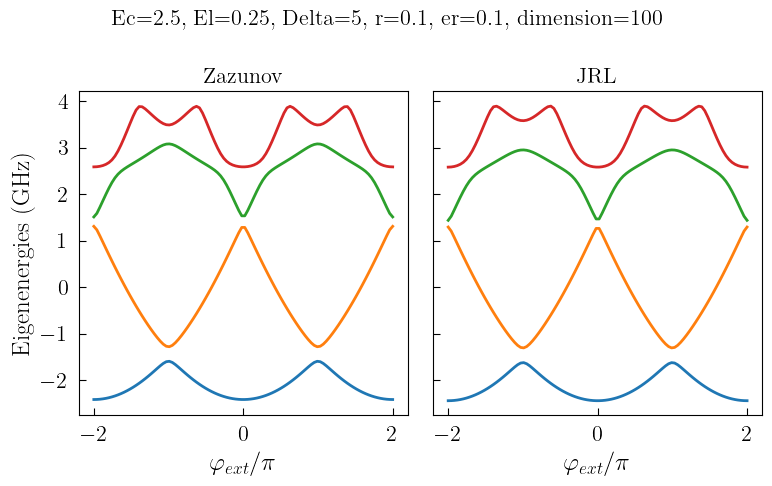

In [343]:
params_str = ', '.join([f'{key}={value}' for key, value in fixed_params.items()])


fig,ax = plt.subplots(1,2, figsize = (8,5),sharey=True)
fig.suptitle(f'{params_str}')
ax[0].plot(phi_ext_array/np.pi,eigenenergies_zazunov)
ax[1].plot(phi_ext_array/np.pi,eigenenergies_jrl)
ax[0].set_ylabel(r'Eigenenergies (GHz)')
ax[0].set_xlabel(r'$\varphi_{ext}/\pi$')
ax[1].set_xlabel(r'$\varphi_{ext}/\pi$')
ax[0].set_title(r'Zazunov')
ax[1].set_title(r'JRL')
fig.tight_layout()
plt.show()

# Comparing both hamiltonians

In [18]:
# def jrl_1D_potential(phase_op, phi_ext, El, r, er):
    # return 1/2*El*(phase_op-phi_ext)**2*qeye(2) + np.cos(phase_op/2)*sigmax() + r*np.sin(phase_op/2)*sigmay() - er*sigmaz()
    # return np.cos(phase_op/2)*sigmax() + r*np.sin(phase_op/2)*sigmay() - er*sigmaz()

def jrl_1D_potential(phase_op, Delta, r, er):
    return Delta*(np.cos(phase_op/2)*sigmax() + r*np.sin(phase_op/2)*sigmay() - er*sigmaz())


## Eigenenergies

Dependance on phi_ext

In [30]:
fixed_params = {
    'Ec': 40,
    'El': 0.05,
    'Delta': 20,
    'r': 0.05,
    'er': 0,
    'dimension': 100,
    
}

phi_ext_array = np.linspace(-2*np.pi, 2*np.pi, 200)
params = fixed_params.copy()
params['model'] = 'jrl'
eigenenergies_jrl = fb.eigen_vs_parameter('phi_ext', phi_ext_array, params, eigvals=2, calculate_states=False, plot=False)

params['model'] = 'zazunov'
eigenenergies_zazunov = fb.eigen_vs_parameter('phi_ext', phi_ext_array, params, eigvals=2, calculate_states=False, plot=False)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [25]:
eigenvals_array = []
for phase_ext in phi_ext_array:
    Delta, r, er =  20, 0.05, 0.0
    eigvals = jrl_1D_potential(phase_ext, Delta, r, er).eigenenergies()
    eigenvals_array.append(eigvals)

eigenvals_array = np.array(eigenvals_array)

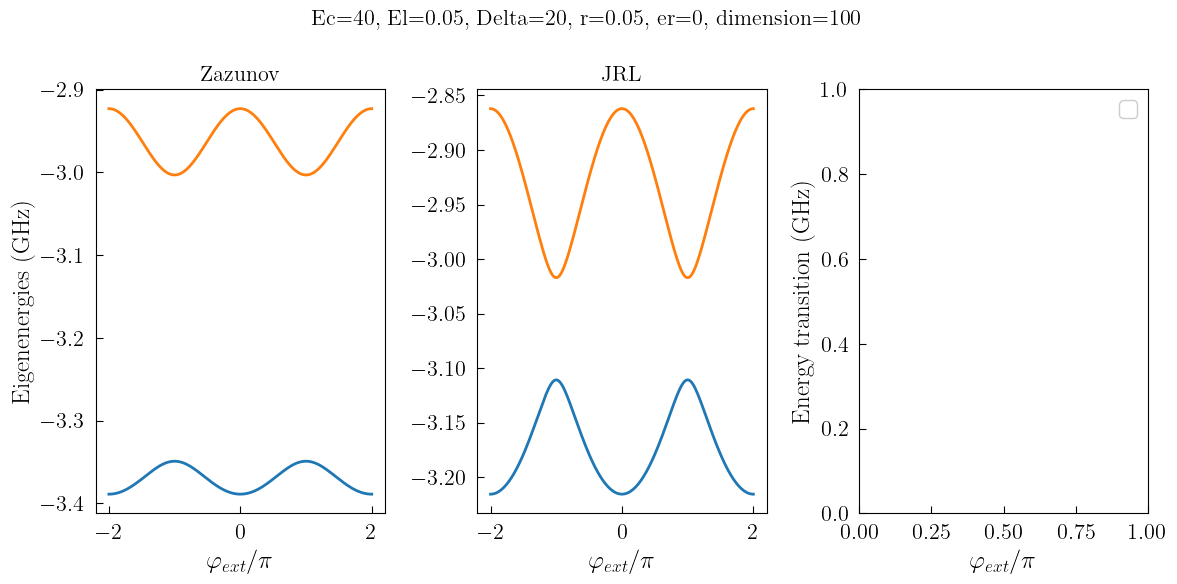

In [31]:
params_str = ', '.join([f'{key}={value}' for key, value in fixed_params.items()])


fig,ax = plt.subplots(1,3, figsize = (12,6),sharey=False)
fig.suptitle(f'{params_str}')
ax[0].plot(phi_ext_array/np.pi,eigenenergies_zazunov)
ax[1].plot(phi_ext_array/np.pi,eigenenergies_jrl)
# ax[2].plot(phi_ext_array/np.pi,eigenenergies_jrl[:,1] -eigenenergies_jrl[:,0], label = 'JRL')
# ax[2].plot(phi_ext_array/np.pi,eigenvals_array[:,1] - eigenvals_array[:,0], '--', color="gray", label = 'ABS')
# ax[1].plot(phi_ext_array/np.pi,eigenvals_array , '--', color="gray")
ax[0].set_ylabel(r'Eigenenergies (GHz)')
ax[2].set_ylabel(r'Energy transition (GHz)')
ax[0].set_xlabel(r'$\varphi_{ext}/\pi$')
ax[1].set_xlabel(r'$\varphi_{ext}/\pi$')
ax[2].set_xlabel(r'$\varphi_{ext}/\pi$')
ax[0].set_title(r'Zazunov')
ax[1].set_title(r'JRL')
ax[2].legend()
fig.tight_layout()
plt.show()

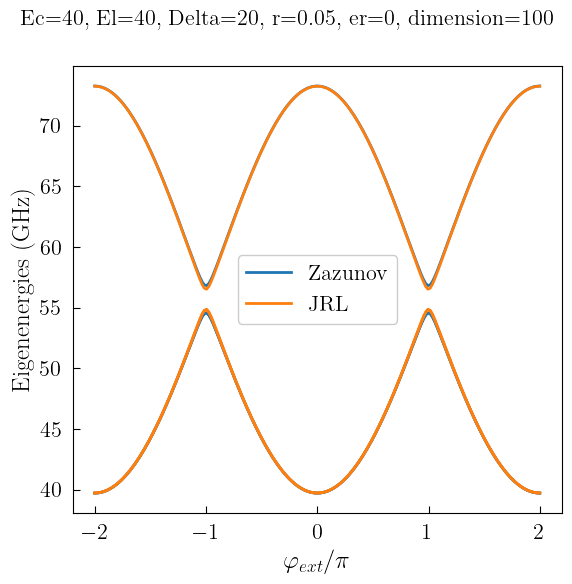

In [282]:
params_str = ', '.join([f'{key}={value}' for key, value in fixed_params.items()])


fig,ax = plt.subplots(1,1, figsize = (6,6))
fig.suptitle(f'{params_str}')
ax.plot(phi_ext_array/np.pi,eigenenergies_zazunov, color='C0')
ax.plot(phi_ext_array/np.pi,eigenenergies_zazunov[:,0], color='C0', label = 'Zazunov')
ax.plot(phi_ext_array/np.pi,eigenenergies_jrl[:,0], color='C1', label = 'JRL')
ax.plot(phi_ext_array/np.pi,eigenenergies_jrl, color='C1')
ax.set_ylabel(r'Eigenenergies (GHz)')
ax.set_xlabel(r'$\varphi_{ext}/\pi$')
ax.legend()
fig.tight_layout()
plt.show()

Dependance on $r$

In [20]:
fixed_params = {
    'Ec': 40,
    'El': 0.05,
    'Delta': 20,
    'er': 0,
    'phi_ext': np.pi,
    'dimension': 100,
    
}

r_array = np.linspace(0.01, 1, 100)
params = fixed_params.copy()
params['model'] = 'jrl'
eigenenergies_jrl = fb.eigen_vs_parameter('r', r_array, params, eigvals=4, calculate_states=False, plot=False)
params = fixed_params.copy()
params['model'] = 'zazunov'
eigenenergies_zazunov = fb.eigen_vs_parameter('r', r_array, params, eigvals=4, calculate_states=False, plot=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

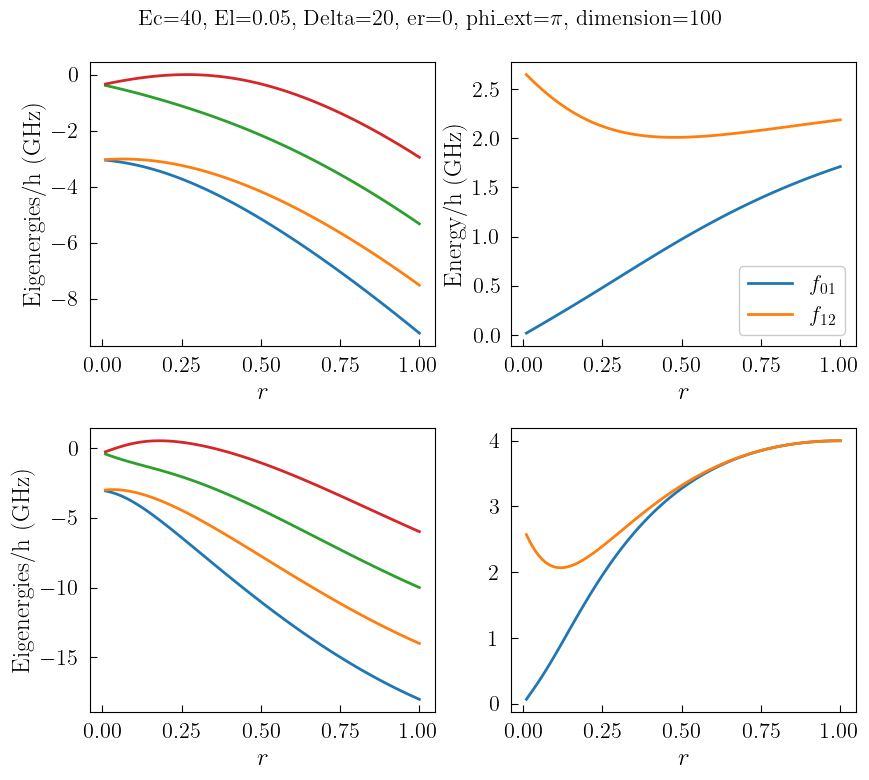

In [22]:
pi_str = "$\\pi$"
params_str = ', '.join([f'{key}={pi_str if value == np.pi else f"{value}"}' for key, value in fixed_params.items()])

fig,ax = plt.subplots(2,2, figsize = (9,8))
fig.suptitle(f'{params_str}')
ax[0,0].plot(r_array,eigenenergies_jrl)
ax[0,1].plot(r_array,eigenenergies_jrl[:,1] - eigenenergies_jrl[:,0], label = r'$f_{01}$')
ax[0,1].plot(r_array,eigenenergies_jrl[:,2] - eigenenergies_jrl[:,1], label = r'$f_{12}$')
# ax[0,1].axhline(y=eigenenergies_zazunov[0,1] - eigenenergies_zazunov[0,0], linestyle = '--', color = 'gray', label = 'Zazunov')
# ax[0,1].axhline(y=eigenenergies_zazunov[0,2] - eigenenergies_zazunov[0,1], linestyle = '--', color = 'gray')
ax[0,1].set_xlabel(r'$r$')
ax[0,0].set_xlabel(r'$r$')
ax[0,1].set_ylabel(r'Energy/h (GHz)')
ax[0,0].set_ylabel(r'Eigenergies/h (GHz)')
ax[1,0].set_ylabel(r'Eigenergies/h (GHz)')
ax[1,0].set_xlabel(r'$r$')
ax[1,1].set_xlabel(r'$r$')
ax[0,1].legend()


ax[1,0].plot(r_array,eigenenergies_zazunov)
ax[1,1].plot(r_array,eigenenergies_zazunov[:,1] - eigenenergies_zazunov[:,0], label = r'$f_{01}$')
ax[1,1].plot(r_array,eigenenergies_zazunov[:,2] - eigenenergies_zazunov[:,1], label = r'$f_{12}$')
fig.tight_layout()
plt.show()

Dependence of $\varepsilon_r$

In [40]:
fixed_params = {
    'Ec': 40,
    'El': 0.05,
    'Delta': 20,
    'r': 0.05,
    'phi_ext' : 0,
    'dimension': 100,
    'model' : 'jrl'
    
}

er_array = np.linspace(-1, 1, 101)
eigenenergies_jrl = fb.eigen_vs_parameter('er', er_array, fixed_params, eigvals=4, calculate_states=False, plot=False, figsize = (9,6))

  0%|          | 0/101 [00:00<?, ?it/s]

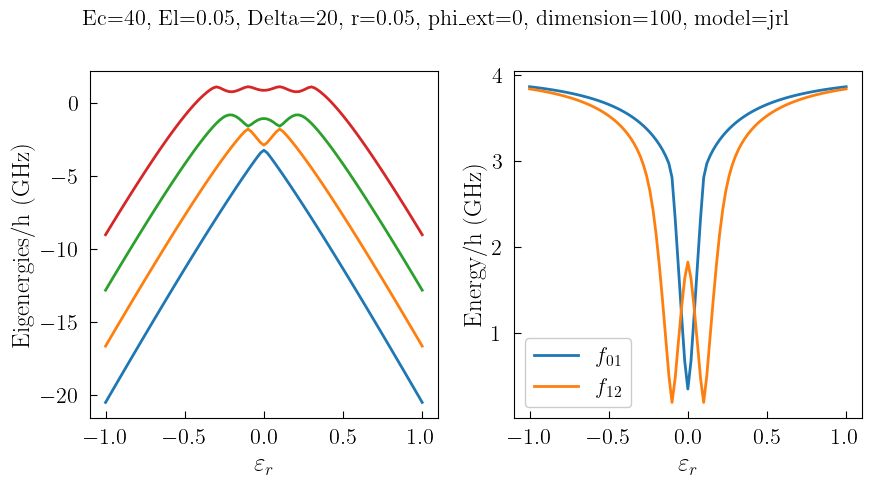

In [41]:
pi_str = "$\\pi$"
params_str = ', '.join([f'{key}={pi_str if value == np.pi else f"{value}"}' for key, value in fixed_params.items()])


fig,ax = plt.subplots(1,2, figsize = (9,5))
fig.suptitle(f'{params_str}')
ax[0].plot(er_array,eigenenergies_jrl)
ax[1].plot(er_array,eigenenergies_jrl[:,1] - eigenenergies_jrl[:,0], label = r'$f_{01}$')
ax[1].plot(er_array,eigenenergies_jrl[:,2] - eigenenergies_jrl[:,1], label = r'$f_{12}$')
# ax[1].axhline(y=eigenenergies_zazunov[0,1] - eigenenergies_zazunov[0,0], linestyle = '--', color = 'gray', label = 'Zazunov')
# ax[1].axhline(y=eigenenergies_zazunov[0,2] - eigenenergies_zazunov[0,1], linestyle = '--', color = 'gray')
ax[1].set_xlabel(r'$\varepsilon_r$')
ax[0].set_xlabel(r'$\varepsilon_r$')
ax[1].set_ylabel(r'Energy/h (GHz)')
ax[0].set_ylabel(r'Eigenergies/h (GHz)')
ax[1].legend()

fig.tight_layout()
plt.show()

In [129]:
fixed_params = {
    'Ec': 40,
    'El': 0.05,
    'Delta': 20,
    'r': 0.05,
    'phi_ext' : np.pi,
    'dimension': 100,
    'model' : 'jrl'
    
}

er_array = np.linspace(-1, 1, 200)
eigenenergies_jrl = fb.eigen_vs_parameter('er', er_array, fixed_params, eigvals=4, calculate_states=False, plot=False, figsize = (9,6))

  0%|          | 0/200 [00:00<?, ?it/s]

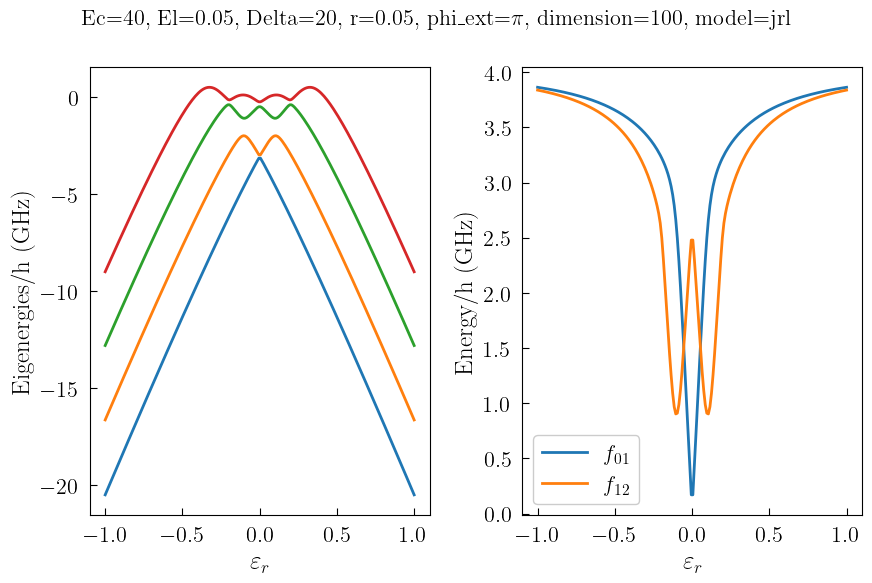

In [130]:
pi_str = "$\\pi$"
params_str = ', '.join([f'{key}={pi_str if value == np.pi else f"{value}"}' for key, value in fixed_params.items()])


fig,ax = plt.subplots(1,2, figsize = (9,6))
fig.suptitle(f'{params_str}')
ax[0].plot(er_array,eigenenergies_jrl)
# ax[0].axhline(y=eigenenergies_zazunov[0,0], linestyle = '--', color = 'gray', label = 'Zazunov')
# ax[0].axhline(y=eigenenergies_zazunov[0,1], linestyle = '--', color = 'gray')
# ax[0].axhline(y=eigenenergies_zazunov[0,2], linestyle = '--', color = 'gray')
# ax[0].axhline(y=eigenenergies_zazunov[0,3], linestyle = '--', color = 'gray')
ax[1].plot(er_array,eigenenergies_jrl[:,1] - eigenenergies_jrl[:,0], label = r'$f_{01}$')
ax[1].plot(er_array,eigenenergies_jrl[:,2] - eigenenergies_jrl[:,1], label = r'$f_{12}$')
# ax[1].axhline(y=eigenenergies_zazunov[0,1] - eigenenergies_zazunov[0,0], linestyle = '--', color = 'gray', label = 'Zazunov')
# ax[1].axhline(y=eigenenergies_zazunov[0,2] - eigenenergies_zazunov[0,1], linestyle = '--', color = 'gray')
ax[1].set_xlabel(r'$\varepsilon_r$')
ax[1].set_ylabel(r'Energy/h (GHz)')
ax[0].set_ylabel(r'Eigenergies/h (GHz)')
ax[0].set_xlabel(r'$\varepsilon_r$')
# ax[0].legend()
ax[1].legend()
fig.tight_layout()
plt.show()

Matrix elements $|\langle 0 | \hat{\phi} | 1 \rangle|^2$

In [131]:
fixed_params = {
    'Ec': 40,
    'El' : 0.05,
    'Delta': 20,
    'r': 0.05,
    'dimension': 100,
}

er_array = np.linspace(-1, 1, 200)

params = fixed_params.copy()
params['model'] = 'jrl'
params['phi_ext'] = 0
matrix_elements_0, eigenenergies_0 = fb.matrix_elements_vs_parameter(parameter_name='er', parameter_values=er_array, operator_name='phase', state_i=0, state_j=1, fixed_params=params, plot = False)

params = fixed_params.copy()
params['model'] = 'jrl'
params['phi_ext'] = np.pi
matrix_elements_pi, eigenenergies_pi = fb.matrix_elements_vs_parameter(parameter_name='er', parameter_values=er_array, operator_name='phase', state_i=0, state_j=1, fixed_params=params, plot = False)

params = fixed_params.copy()
params['model'] = 'zazunov'
phi_ext_array = np.linspace(0,0,1)
matrix_elements_z_0, eigenenergies_z_0 = fb.matrix_elements_vs_parameter(parameter_name='phi_ext', parameter_values=phi_ext_array, operator_name='phase', state_i=0, state_j=1, fixed_params=params, plot = False)

phi_ext_array = np.linspace(np.pi,np.pi,1)
matrix_elements_z_pi, eigenenergies_z_pi = fb.matrix_elements_vs_parameter(parameter_name='phi_ext', parameter_values=phi_ext_array, operator_name='phase', state_i=0, state_j=1, fixed_params=params, plot = False)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

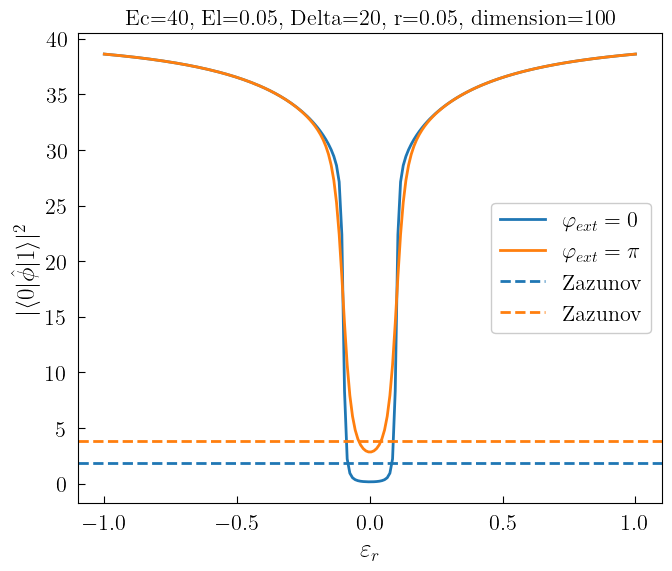

In [155]:
params_str = ', '.join([f'{key}={value}' for key, value in fixed_params.items()])


fig,ax = plt.subplots(1,1, figsize = (7,6))
ax.set_title(f'{params_str}')
ax.plot(er_array,np.abs(matrix_elements_0)**2, label = r'$\varphi_{ext} = 0$')
ax.plot(er_array,np.abs(matrix_elements_pi)**2, label = r'$\varphi_{ext} = \pi$')
ax.axhline(np.abs(matrix_elements_z_0)**2, linestyle = '--', color = 'C0', label = 'Zazunov')
ax.axhline(np.abs(matrix_elements_z_pi)**2, linestyle = '--', color = 'C1', label = 'Zazunov')
ax.set_xlabel(r'$\varepsilon_r$')
ax.set_ylabel(r'$|\langle 0 | \hat{\phi} | 1 \rangle|^2$')
ax.legend()
fig.tight_layout()
plt.show()

Matrix elements $|\langle 0 | \partial\hat{H}/\partial r | 1 \rangle|^2$

In [132]:
fixed_params = {
    'Ec': 40,
    'El' : 0.05,
    'Delta': 20,
    'r': 0.05,
    'dimension': 100,
}

er_array = np.linspace(-1, 1, 401)

params = fixed_params.copy()
params['model'] = 'jrl'
params['phi_ext'] = 0
matrix_elements_0, eigenenergies_0 = fb.matrix_elements_vs_parameter(parameter_name='er', parameter_values=er_array, operator_name='dHdr', state_i=0, state_j=1, fixed_params=params, plot = False)

params = fixed_params.copy()
params['model'] = 'jrl'
params['phi_ext'] = np.pi
matrix_elements_pi, eigenenergies_pi = fb.matrix_elements_vs_parameter(parameter_name='er', parameter_values=er_array, operator_name='dHdr', state_i=0, state_j=1, fixed_params=params, plot = False)

params = fixed_params.copy()
params['model'] = 'zazunov'
phi_ext_array = np.linspace(0,0,1)
matrix_elements_z_0, eigenenergies_z_0 = fb.matrix_elements_vs_parameter(parameter_name='phi_ext', parameter_values=phi_ext_array, operator_name='dHdr', state_i=0, state_j=1, fixed_params=params, plot = False)

phi_ext_array = np.linspace(np.pi,np.pi,1)
matrix_elements_z_pi, eigenenergies_z_pi = fb.matrix_elements_vs_parameter(parameter_name='phi_ext', parameter_values=phi_ext_array, operator_name='dHdr', state_i=0, state_j=1, fixed_params=params, plot = False)

  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

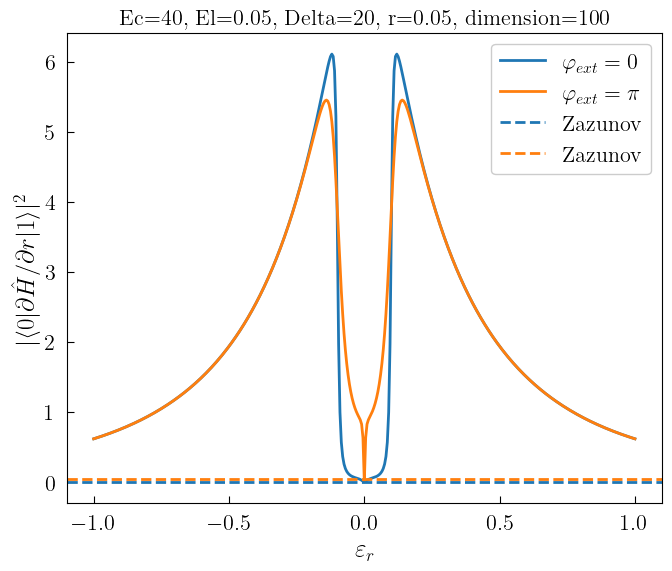

In [161]:
params_str = ', '.join([f'{key}={value}' for key, value in fixed_params.items()])


fig,ax = plt.subplots(1,1, figsize = (7,6))
ax.set_title(f'{params_str}')
ax.plot(er_array,np.abs(matrix_elements_0)**2, label = r'$\varphi_{ext} = 0$')
ax.plot(er_array,np.abs(matrix_elements_pi)**2, label = r'$\varphi_{ext} = \pi$')
ax.axhline(np.abs(matrix_elements_z_0)**2, linestyle = '--', color = 'C0', label = 'Zazunov')
ax.axhline(np.abs(matrix_elements_z_pi)**2, linestyle = '--', color = 'C1', label = 'Zazunov')
ax.set_xlabel(r'$\varepsilon_r$')
ax.set_ylabel(r'$|\langle 0 | \partial\hat{H}/\partial r | 1 \rangle|^2$')
ax.legend()
fig.tight_layout()
plt.show()

## Wavefunctions

In [463]:
def phi_n(Ec,El, n: int,phi_list):
    # CONVERT THE FOCK SPACE STATES IN HARMONIC OSCILLATOR WAVEFUNCTIONS
    phi_ZPF=(8.0 * Ec / El) ** 0.25      
    normalization  = 1/np.sqrt(np.sqrt(np.pi)*(2**n) * 1.0 * phi_ZPF * factorial(n))
    return normalization* np.exp(-(phi_list/phi_ZPF)**2 / 2.0) * np.polyval(hermite(n), (phi_list/phi_ZPF))


def wavefunction_phi_fbq_up(Ec,El,phi_list,phi,N):
    # Wavefunction(\varphi) FOR \sigmaz = +1 OF AN EIGENSTATE OF THE Fermionic-Bosonic Qubit.

    wfunc = np.zeros(len(phi_list),dtype = complex)
    for n in range(N//2+1):
        wfunc = wfunc + phi_n(Ec,El,n,phi_list)*phi.full()[2*n,0]
    return wfunc

def wavefunction_phi_fbq_down(Ec,El,phi_list,phi,N):
    # Wavefunction(\varphi) FOR \sigmaz = -1 OF AN EIGENSTATE OF THE Fermionic-Bosonic Qubit.

    wfunc = np.zeros(len(phi_list),dtype = complex)
    for n in range(N//2):
        wfunc = wfunc + phi_n(Ec,El,n,phi_list)*phi.full()[2*n+1,0]
    return wfunc

In [566]:
fixed_params = {
    'Ec': 4,
    'El': 0.05,
    'Delta': 20,
    'r': 0.05,
    'er': 0,
    'phi_ext': np.pi,
    'dimension': 100,
}

params = fixed_params.copy()
params['model'] = 'zazunov'
hamil = fb.hamiltonian(**params)
eigvals_z,eigvecs_z = hamil.eigenstates(eigvals=3)

params = fixed_params.copy()
params['model'] = 'jrl'
hamil = fb.hamiltonian(**params)
eigvals_jrl,eigvecs_jrl = hamil.eigenstates(eigvals=3)

In [567]:
phi_list=np.linspace(-6*np.pi,6*np.pi,500)
zero_down_z = np.abs(wavefunction_phi_fbq_down(params['Ec'],params['El'],phi_list,eigvecs_z[0],params['dimension']))**2
one_up_z = np.abs(wavefunction_phi_fbq_up(params['Ec'],params['El'],phi_list,eigvecs_z[1],params['dimension']))**2

zero_up_z = np.abs(wavefunction_phi_fbq_up(params['Ec'],params['El'],phi_list,eigvecs_z[0],params['dimension']))**2
one_down_z = np.abs(wavefunction_phi_fbq_down(params['Ec'],params['El'],phi_list,eigvecs_z[1],params['dimension']))**2


zero_down_jrl = np.abs(wavefunction_phi_fbq_down(params['Ec'],params['El'],phi_list,eigvecs_jrl[0],params['dimension']))**2
one_up_jrl = np.abs(wavefunction_phi_fbq_up(params['Ec'],params['El'],phi_list,eigvecs_jrl[1],params['dimension']))**2

zero_up_jrl = np.abs(wavefunction_phi_fbq_up(params['Ec'],params['El'],phi_list,eigvecs_jrl[0],params['dimension']))**2
one_down_jrl = np.abs(wavefunction_phi_fbq_down(params['Ec'],params['El'],phi_list,eigvecs_jrl[1],params['dimension']))**2

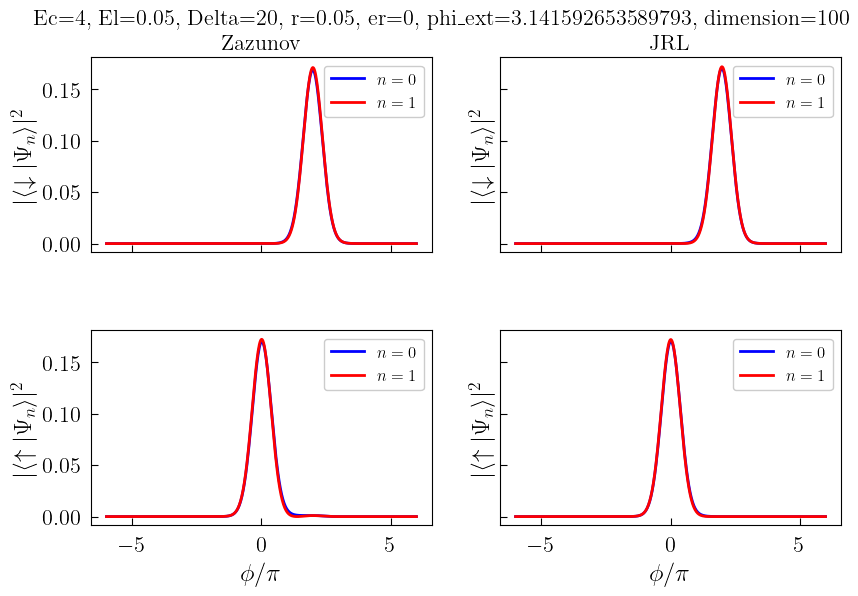

In [568]:
params_str = ', '.join([f'{key}={value}' for key, value in fixed_params.items()])

plt.close('all')
fig,ax = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)
fig.suptitle(f'{params_str}')

ax[0,0].set_title('Zazunov')
ax[0,0].plot(phi_list/np.pi,zero_down_z, label = r'$n=0$', color = 'blue')
ax[0,0].plot(phi_list/np.pi,one_down_z, label = r'$n =1$', color = 'red')
ax[1,0].plot(phi_list/np.pi,zero_up_z, label = r'$n=0$', color = 'blue')
ax[1,0].plot(phi_list/np.pi,one_up_z, label = r'$n=1$', color = 'red')
ax[0,0].set_ylabel(r'$|\langle \downarrow|\Psi_n\rangle|^2$')
ax[1,0].set_ylabel(r'$|\langle \uparrow|\Psi_n\rangle|^2$')
ax[1,0].set_xlabel(r'$\phi/\pi$')
# ax[0,0].legend()
# ax[1,0].legend()

ax[0,1].set_title('JRL')
ax[0,1].plot(phi_list/np.pi,zero_down_jrl, label = r'$n=0$', color = 'blue')
ax[0,1].plot(phi_list/np.pi,one_down_jrl, label = r'$n =1$', color = 'red')
ax[1,1].plot(phi_list/np.pi,zero_up_jrl, label = r'$n=0$', color = 'blue')
ax[1,1].plot(phi_list/np.pi,one_up_jrl, label = r'$n=1$', color = 'red')
ax[0,1].set_ylabel(r'$|\langle \downarrow|\Psi_n\rangle|^2$')
ax[1,1].set_ylabel(r'$|\langle \uparrow|\Psi_n\rangle|^2$')
ax[1,1].set_xlabel(r'$\phi/\pi$')
# ax[0,1].legend()
# ax[1,1].legend()

[axs.legend(fontsize = 12) for rows in ax for axs in rows]
plt.show()

## Potential

In [ ]:
gap = 0.1
phase_list = np.linspace(-2*np.pi, 2*np.pi,200)
eigenvals_array = []
eigenvals_array_r = []
eigenvals_array_er = []
for phase_op in phase_list:
    phi_ext, El, r, er = 0, 0.05, 0., 0.
    eigvals = jrl_1D_potential(phase_op,phi_ext, El, r, er).eigenenergies()
    eigenvals_array.append(eigvals)

    El, r, er = 0.05, 0.3, 0.
    eigvals = jrl_1D_potential(phase_op,phi_ext, El, r, er).eigenenergies()
    eigenvals_array_r.append(eigvals)

    El, r, er = 0.05, 0., 0.3
    eigvals = jrl_1D_potential(phase_op,phi_ext, El, r, er).eigenenergies()
    eigenvals_array_er.append(eigvals)

eigenvals_array = np.array(eigenvals_array)
eigenvals_array_r = np.array(eigenvals_array_r)
eigenvals_array_er = np.array(eigenvals_array_er)

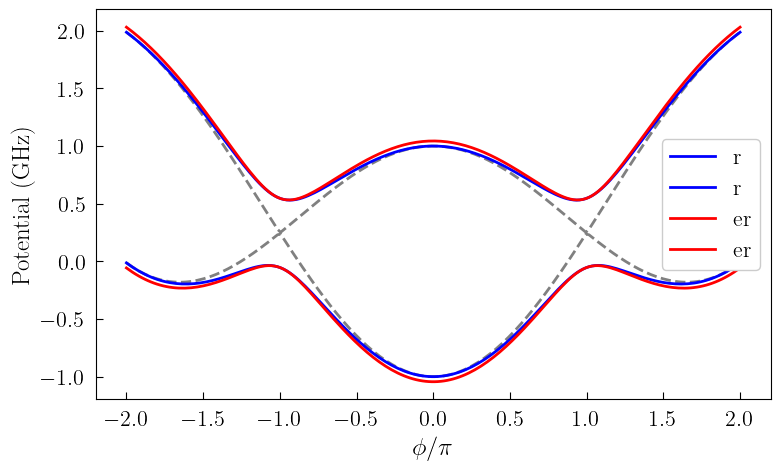

In [134]:
fig, ax = plt.subplots(1,1, figsize = (9,5))
ax.plot(phase_list/np.pi,eigenvals_array, color = 'gray', linestyle='--')
ax.plot(phase_list/np.pi,eigenvals_array_r, color = 'blue', label = 'r')
ax.plot(phase_list/np.pi,eigenvals_array_er, color = 'red', label = 'er')
# ax.plot(phase_list/np.pi,eigenvals_array_r_01, color = 'blue')

ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'Potential (GHz)')
ax.legend()
# ax.set_title(rf'$E_L =$ {El}, $r = $ {r}, $\varepsilon_r = $ {er}')
plt.show()

# Josephson Resonance Level

In [371]:
def procesar(i):
    # Reemplaza esto con tu operación real
    return i * i

resultados = Parallel(n_jobs=-1)(delayed(procesar)(i) for i in range(10))

In [385]:
def sumar(a, b):
    # Simula una operación más intensiva en cómputo
    return a + b

# Crear arrays de NumPy
a_vals = np.array([1, 2, 3, 4])
b_vals = np.array([5, 6, 7, 8])

# Genera todas las combinaciones posibles de a_vals y b_vals
# Nota: product() devuelve iteradores, los convertimos en arrays de NumPy para cada par
combinaciones = list(product(a_vals, b_vals))

# Ejecuta la función sumar en paralelo para cada combinación
# Aquí, combinaciones[:, 0] es un array de todos los primeros elementos de las combinaciones,
# y combinaciones[:, 1] es un array de todos los segundos elementos.
resultados = Parallel(n_jobs=-1)(
    delayed(sumar)(a, b) for a, b in combinaciones
    )

resultados = np.array(resultados)
resultados = np.reshape(resultados,(len(a_vals),-1))
resultados

array([[ 6,  7,  8,  9],
       [ 7,  8,  9, 10],
       [ 8,  9, 10, 11],
       [ 9, 10, 11, 12]])

In [7]:
fixed_params = {
    'Ec': 40,
    'El': 0.05,
    'Delta': 20,
    'r': 0.05,
    'er': 0.05,
    'phi_ext' : 0,
    'dimension': 100,
    'model' : 'jrl'
}

In [8]:
El_array = np.geomspace(0.05, 50, 101)
dHder_me_El = fb.matrix_elements_vs_parameter('El', El_array,operator_name='dHder',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
dHdr_me_El = fb.matrix_elements_vs_parameter('El', El_array,operator_name='dHdr',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
phase_me_El = fb.matrix_elements_vs_parameter('El', El_array,operator_name='phase',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
df01_dphiext_El = fb.derivative_eigenenergies('phi_ext','El', El_array, fixed_params = fixed_params, eigvals=2, plot=False)
df01_dr_El = fb.derivative_eigenenergies('r','El', El_array, fixed_params = fixed_params, eigvals=2, plot=False)
df01_der_El = fb.derivative_eigenenergies('er','El', El_array, fixed_params = fixed_params, eigvals=2, plot=False)

Ec_array = np.geomspace(1, 50, 101)
dHder_me_Ec = fb.matrix_elements_vs_parameter('Ec', Ec_array,operator_name='dHder',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
dHdr_me_Ec = fb.matrix_elements_vs_parameter('Ec', Ec_array,operator_name='dHdr',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
phase_me_Ec = fb.matrix_elements_vs_parameter('Ec', Ec_array,operator_name='phase',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
df01_dphiext_Ec = fb.derivative_eigenenergies('phi_ext','Ec', Ec_array, fixed_params = fixed_params, eigvals=2, plot=False)
df01_dr_Ec = fb.derivative_eigenenergies('r','Ec', Ec_array, fixed_params = fixed_params, eigvals=2, plot=False)
df01_der_Ec = fb.derivative_eigenenergies('er','Ec', Ec_array, fixed_params = fixed_params, eigvals=2, plot=False)

Delta_array = np.linspace(10, 40, 101)
dHder_me_Delta = fb.matrix_elements_vs_parameter('Delta', Delta_array,operator_name='dHder',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
dHdr_me_Delta = fb.matrix_elements_vs_parameter('Delta', Delta_array,operator_name='dHdr',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
phase_me_Delta = fb.matrix_elements_vs_parameter('Delta', Delta_array,operator_name='phase',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
df01_dphiext_Delta = fb.derivative_eigenenergies('phi_ext','Delta', Delta_array, fixed_params = fixed_params, eigvals=2, plot=False)
df01_dr_Delta = fb.derivative_eigenenergies('r','Delta', Delta_array, fixed_params = fixed_params, eigvals=2, plot=False)
df01_der_Delta = fb.derivative_eigenenergies('er','Delta', Delta_array, fixed_params = fixed_params, eigvals=2, plot=False)

er_array = np.linspace(0.01, 0.5, 101)
dHder_me_er = fb.matrix_elements_vs_parameter('er', er_array,operator_name='dHder',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
dHdr_me_er = fb.matrix_elements_vs_parameter('er', er_array,operator_name='dHdr',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
phase_me_er = fb.matrix_elements_vs_parameter('er', er_array,operator_name='phase',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
df01_dphiext_er = fb.derivative_eigenenergies('phi_ext','er', er_array, fixed_params = fixed_params, eigvals=2, plot=False)
df01_dr_er = fb.derivative_eigenenergies('r','er', er_array, fixed_params = fixed_params, eigvals=2, plot=False)
df01_der_er = fb.derivative_eigenenergies('er','er', er_array, fixed_params = fixed_params, eigvals=2, plot=False)

r_array = np.linspace(0.01, 1, 101)
dHder_me_r = fb.matrix_elements_vs_parameter('r', r_array,operator_name='dHder',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
dHdr_me_r = fb.matrix_elements_vs_parameter('r', r_array,operator_name='dHdr',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
phase_me_r = fb.matrix_elements_vs_parameter('r', r_array,operator_name='phase',fixed_params=fixed_params, eigvals=3,plot=False, log_scale=False)
df01_dphiext_r = fb.derivative_eigenenergies('phi_ext','r', r_array, fixed_params = fixed_params, eigvals=2, plot=False)
df01_dr_r = fb.derivative_eigenenergies('r','r', r_array, fixed_params = fixed_params, eigvals=2, plot=False)
df01_der_r = fb.derivative_eigenenergies('er','r', r_array, fixed_params = fixed_params, eigvals=2, plot=False)

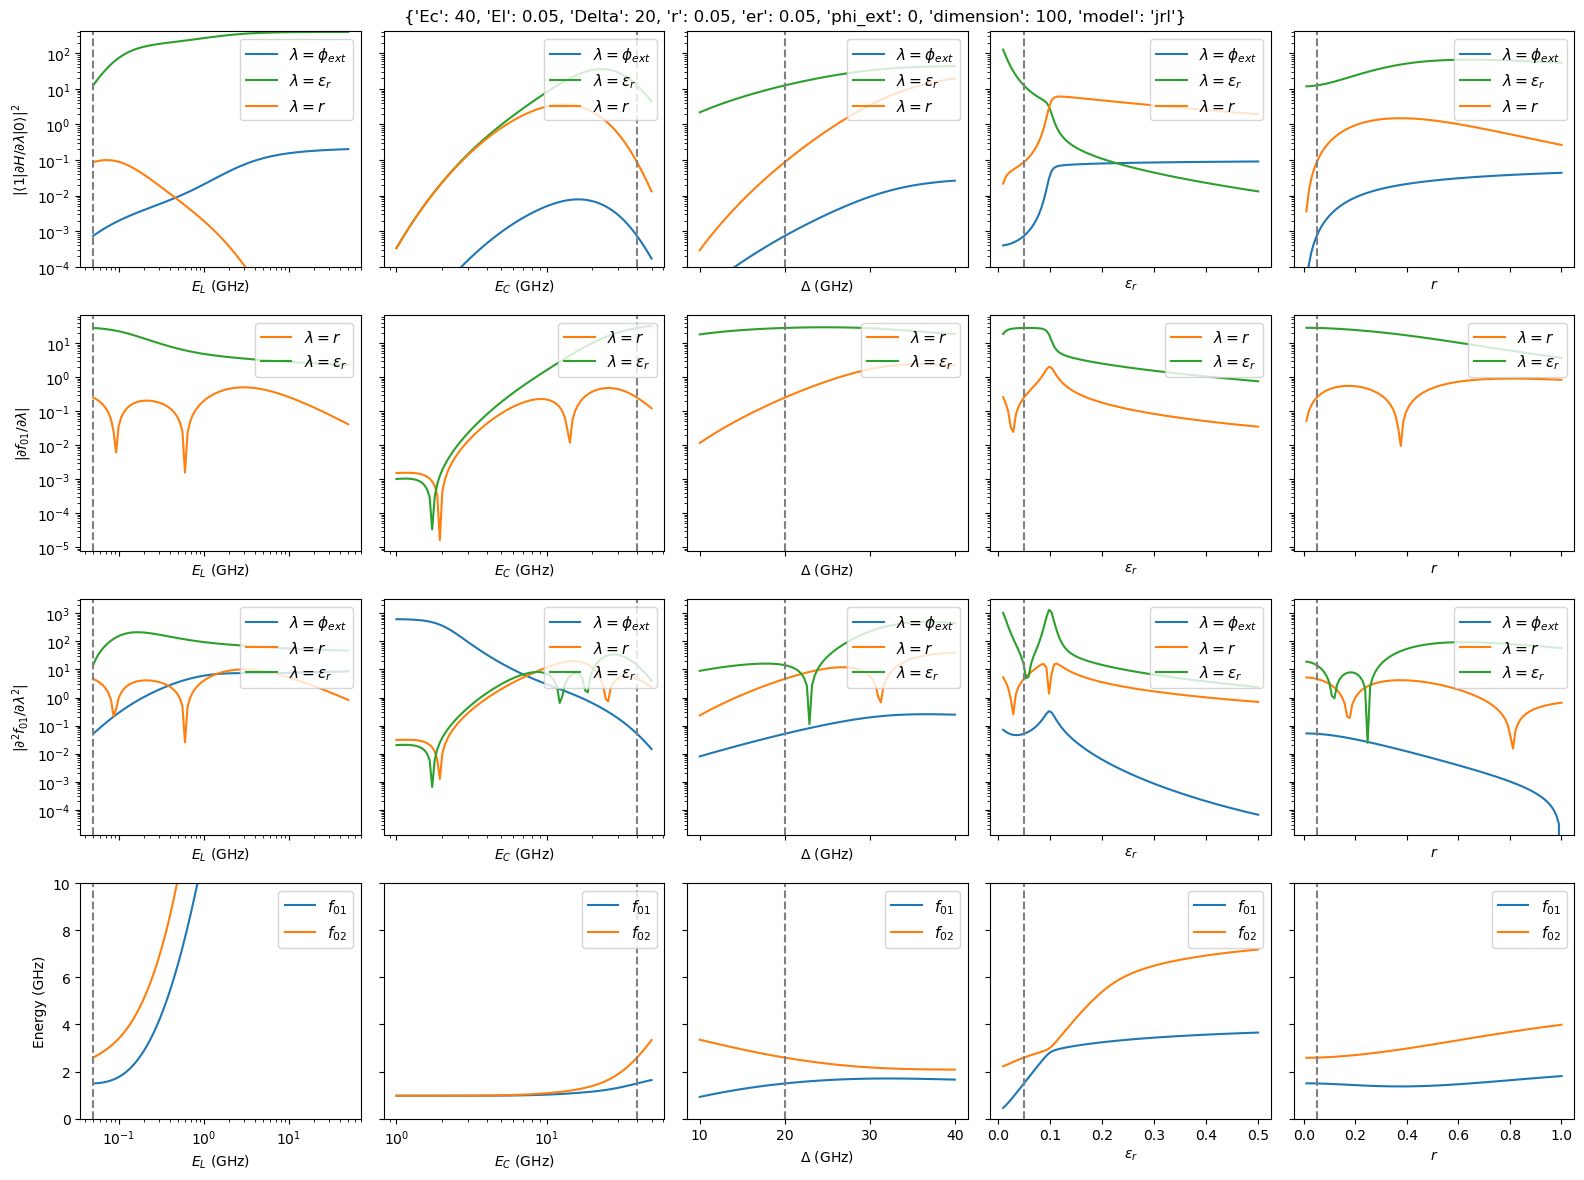

In [16]:
fig,ax = plt.subplots(4,5, sharey='row', sharex='col', figsize=(16,12))
fig.suptitle(f'{fixed_params}')

ax[0,0].plot(El_array,np.abs(phase_me_El[0]*El_array)**2, color='C0',label=r'$\lambda = \phi_{ext}$')
ax[0,1].plot(Ec_array,np.abs(phase_me_Ec[0]*0.05)**2, color='C0',label=r'$\lambda = \phi_{ext}$')
ax[0,2].plot(Delta_array,np.abs(phase_me_Delta[0]*0.05)**2, color='C0',label=r'$\lambda = \phi_{ext}$')
ax[0,3].plot(er_array,np.abs(phase_me_er[0]*0.05)**2, color='C0',label=r'$\lambda = \phi_{ext}$')
ax[0,4].plot(r_array,np.abs(phase_me_r[0]*0.05)**2, color='C0',label=r'$\lambda = \phi_{ext}$')

ax[3,0].plot(El_array,dHder_me_El[1][:,1] - dHder_me_El[1][:,0], label=r'$f_{01}$')
ax[3,1].plot(Ec_array,dHder_me_Ec[1][:,1] - dHder_me_Ec[1][:,0], label=r'$f_{01}$')
ax[3,2].plot(Delta_array,dHder_me_Delta[1][:,1] - dHder_me_Delta[1][:,0], label=r'$f_{01}$')
ax[3,3].plot(er_array,dHder_me_er[1][:,1] - dHder_me_er[1][:,0], label=r'$f_{01}$')
ax[3,4].plot(r_array,dHder_me_r[1][:,1] - dHder_me_r[1][:,0], label=r'$f_{01}$')

ax[3,0].plot(El_array,dHder_me_El[1][:,2] - dHder_me_El[1][:,0], label=r'$f_{02}$')
ax[3,1].plot(Ec_array,dHder_me_Ec[1][:,2] - dHder_me_Ec[1][:,0], label=r'$f_{02}$')
ax[3,2].plot(Delta_array,dHder_me_Delta[1][:,2] - dHder_me_Delta[1][:,0], label=r'$f_{02}$')
ax[3,3].plot(er_array,dHder_me_er[1][:,2] - dHder_me_er[1][:,0], label=r'$f_{02}$')
ax[3,4].plot(r_array,dHder_me_r[1][:,2] - dHder_me_r[1][:,0], label=r'$f_{02}$')

ax[0,0].plot(El_array,np.abs(dHder_me_El[0])**2, color='C02',label = r'$\lambda = \varepsilon_r $')
ax[0,1].plot(Ec_array,np.abs(dHder_me_Ec[0])**2, color='C02',label = r'$\lambda = \varepsilon_r $')
ax[0,2].plot(Delta_array,np.abs(dHder_me_Delta[0])**2, color='C02',label = r'$\lambda = \varepsilon_r $')
ax[0,3].plot(er_array,np.abs(dHder_me_er[0])**2, color='C02',label = r'$\lambda = \varepsilon_r $')
ax[0,4].plot(r_array,np.abs(dHder_me_r[0])**2, color='C02',label = r'$\lambda = \varepsilon_r $')

ax[0,0].plot(El_array,np.abs(dHdr_me_El[0])**2, color='C01',label = r'$\lambda = r $')
ax[0,1].plot(Ec_array,np.abs(dHdr_me_Ec[0])**2, color='C01',label = r'$\lambda = r $')
ax[0,2].plot(Delta_array,np.abs(dHdr_me_Delta[0])**2, color='C01',label = r'$\lambda = r $')
ax[0,3].plot(er_array,np.abs(dHdr_me_er[0])**2, color='C01',label = r'$\lambda = r $')
ax[0,4].plot(r_array,np.abs(dHdr_me_r[0])**2, color='C01',label = r'$\lambda = r $')

ax[1,0].plot(El_array,np.abs(df01_dr_El[0]), color='C1',label = r'$\lambda = r$')
ax[1,1].plot(Ec_array,np.abs(df01_dr_Ec[0]), color='C1',label = r'$\lambda = r$')
ax[1,2].plot(Delta_array,np.abs(df01_dr_Delta[0]), color='C1',label = r'$\lambda = r$')
ax[1,3].plot(er_array,np.abs(df01_dr_er[0]), color='C1',label = r'$\lambda = r$')
ax[1,4].plot(r_array,np.abs(df01_dr_r[0]), color='C1',label = r'$\lambda = r$')

ax[1,0].plot(El_array,np.abs(df01_der_El[0]), color='C02',label = r'$\lambda = \varepsilon_r$')
ax[1,1].plot(Ec_array,np.abs(df01_der_Ec[0]), color='C02',label = r'$\lambda = \varepsilon_r$')
ax[1,2].plot(Delta_array,np.abs(df01_der_Delta[0]), color='C02',label = r'$\lambda = \varepsilon_r$')
ax[1,3].plot(er_array,np.abs(df01_der_er[0]), color='C02',label = r'$\lambda = \varepsilon_r$')
ax[1,4].plot(r_array,np.abs(df01_der_r[0]), color='C02',label = r'$\lambda = \varepsilon_r$')

ax[2,0].plot(El_array,np.abs(df01_dphiext_El[1]), color='C0',label = r'$\lambda = \phi_{ext}$')
ax[2,1].plot(Ec_array,np.abs(df01_dphiext_Ec[1]), color='C0',label = r'$\lambda = \phi_{ext}$')
ax[2,2].plot(Delta_array,np.abs(df01_dphiext_Delta[1]), color='C0',label = r'$\lambda = \phi_{ext}$')
ax[2,3].plot(er_array,np.abs(df01_dphiext_er[1]), color='C0',label = r'$\lambda = \phi_{ext}$')
ax[2,4].plot(r_array,np.abs(df01_dphiext_r[1]), color='C0',label = r'$\lambda = \phi_{ext}$')

ax[2,0].plot(El_array,np.abs(df01_dr_El[1]), color='C01',label = r'$\lambda = r $')
ax[2,1].plot(Ec_array,np.abs(df01_dr_Ec[1]), color='C01',label = r'$\lambda = r $')
ax[2,2].plot(Delta_array,np.abs(df01_dr_Delta[1]), color='C01',label = r'$\lambda = r $')
ax[2,3].plot(er_array,np.abs(df01_dr_er[1]), color='C01',label = r'$\lambda = r $')
ax[2,4].plot(r_array,np.abs(df01_dr_r[1]), color='C01',label = r'$\lambda = r $')

ax[2,0].plot(El_array,np.abs(df01_der_El[1]), color='C02',label = r'$\lambda = \varepsilon_r $')
ax[2,1].plot(Ec_array,np.abs(df01_der_Ec[1]), color='C02',label = r'$\lambda = \varepsilon_r $')
ax[2,2].plot(Delta_array,np.abs(df01_der_Delta[1]), color='C02',label = r'$\lambda = \varepsilon_r $')
ax[2,3].plot(er_array,np.abs(df01_der_er[1]), color='C02',label = r'$\lambda = \varepsilon_r $')
ax[2,4].plot(r_array,np.abs(df01_der_r[1]), color='C02',label = r'$\lambda = \varepsilon_r $')

for i in range(4):
    ax[i,0].set_xlabel(r'$E_L$ (GHz)')
    ax[i,1].set_xlabel(r'$E_C$ (GHz)')
    ax[i,2].set_xlabel(r'$\Delta$ (GHz)')
    ax[i,3].set_xlabel(r'$\varepsilon_r$')
    ax[i,4].set_xlabel(r'$r$')

    ax[i,0].axvline(x=0.05, linestyle = '--', color='gray')
    ax[i,1].axvline(x=40, linestyle = '--', color='gray')
    ax[i,2].axvline(x=20, linestyle = '--', color='gray')
    ax[i,3].axvline(x=0.05, linestyle = '--', color='gray')
    ax[i,4].axvline(x=0.05, linestyle = '--', color='gray')


ax[0,0].set_ylim(bottom=10e-5)
# ax[1,0].set_ylim([10e-5,10e2])
# ax[1,0].set_ylim(bottom=10e-3)
# ax[2,0].set_ylim(bottom=10e-3)
ax[3,0].set_ylim(bottom=0,top=10)

ax[0,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[2,0].set_yscale('log')
# ax[3,0].set_yscale('log')
ax[0,0].set_yscale('log')

ax[0,1].set_xscale('log')
# ax[0,3].set_xscale('log')
# ax[0,4].set_xscale('log')


[axs.legend(fontsize=11, loc = 'upper right') for row in ax for axs in row]

ax[0,0].set_ylabel(r'$|\langle 1 | \partial H/\partial \lambda | 0 \rangle|^2$')
ax[1,0].set_ylabel(r'$|\partial f_{01}/\partial \lambda|$')
ax[2,0].set_ylabel(r'$|\partial^2 f_{01}/\partial \lambda^2|$')
ax[3,0].set_ylabel('Energy (GHz)')

fig.tight_layout()
plt.show()

# Quantum dot level

Symbolic expression of the eigenvalues

In [364]:
# Definir los símbolos
e1, e2, u, t12, Gamma1, Gamma2, phi = sp.symbols('e1 e2 u t12 Gamma1 Gamma2 phi', real=True)

# Crear la matriz simbólica
ind_matrix = sp.Matrix([
    [0, 0,        0,         0,           0,                    0],
    [0, 2*e1+u,   t12,      -t12,         0,                    0],
    [0, t12,      e1 + e2,   0,           t12,                  0],
    [0, -t12,     0,         e1 + e2,    -t12,                  0],
    [0, 0,        t12,       -t12,        2*e2 + u,             0],
    [0, 0,        0,         0,           0,          2*(e1+e2+u)],
])

# Añadir los términos con exponenciales complejos
ind_matrix[0, 1] = ind_matrix[4, 5] = Gamma1 * sp.exp(-1j * phi / 2)
ind_matrix[1, 0] = ind_matrix[5, 4] = Gamma1 * sp.exp(1j * phi / 2)
ind_matrix[0, 4] = ind_matrix[1, 5] = Gamma2 * sp.exp(1j * phi / 2)
ind_matrix[4, 0] = ind_matrix[5, 1] = Gamma2 * sp.exp(-1j * phi / 2)


In [365]:
ind_matrix

Matrix([
[                     0, Gamma1*exp(-0.5*I*phi),       0,       0, Gamma2*exp(0.5*I*phi),                      0],
[ Gamma1*exp(0.5*I*phi),               2*e1 + u,     t12,    -t12,                     0,  Gamma2*exp(0.5*I*phi)],
[                     0,                    t12, e1 + e2,       0,                   t12,                      0],
[                     0,                   -t12,       0, e1 + e2,                  -t12,                      0],
[Gamma2*exp(-0.5*I*phi),                      0,     t12,    -t12,              2*e2 + u, Gamma1*exp(-0.5*I*phi)],
[                     0, Gamma2*exp(-0.5*I*phi),       0,       0, Gamma1*exp(0.5*I*phi),      2*e1 + 2*e2 + 2*u]])

Phase as a classical operator

In [29]:
def classical_hamiltonian(Gamma1, Gamma2, t12, e1,e2,u, clas_phase):

    matrix = np.array([
        [0, 0,      0,       0,         0,                    0],
        [0, 2*e1+u, t12,    -t12,       0,                    0],
        [0, 0,      e1 + e2, 0,         t12,                  0],
        [0, 0,      0,       e1 + e2,  -t12,                  0],
        [0, 0,      0,       0,         2*e2 + u,             0],
        [0, 0,      0,       0,         0,          2*(e1+e2+u)],
    ], dtype=complex)

    matrix[0,1] = matrix[4,5] = Gamma1*np.exp(-1j*clas_phase/2)
    matrix[0,4] = matrix[1,5] = Gamma2*np.exp(1j*clas_phase/2)
    upper_tri = np.triu(matrix)
    ind_matrix = upper_tri + upper_tri.T.conjugate() - np.diag(np.diag(matrix))
    ind_matrix = Qobj(ind_matrix)

    return ind_matrix

In [97]:
Gamma1  = 10
Gamma2 = 10
t12 = 10
e1,e2,u = 5,5, 0

clas_phase_array = np.linspace(0,2*np.pi,100)
clas_eigvals_array = np.zeros((len(clas_phase_array), 6))
eigvecs_array = []
for i,clas_phase in enumerate(clas_phase_array):
    h = classical_hamiltonian(Gamma1, Gamma2, t12, e1,e2,u, clas_phase)
    evals,eigvecs = h.eigenstates()
    clas_eigvals_array[i] = evals
    eigvecs_array.append(eigvecs)

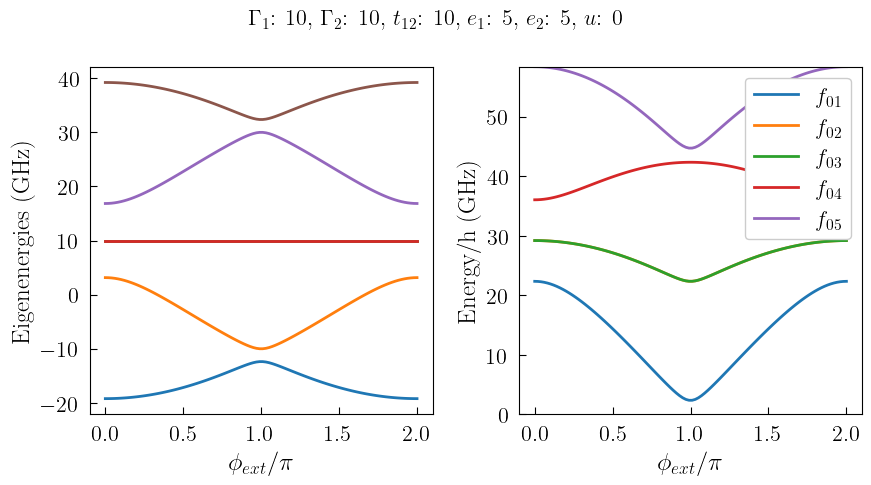

In [98]:
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(9, 5))

title = rf'$\Gamma_1$: {Gamma1}, $\Gamma_2$: {Gamma2}, $t_{{12}}$: {t12}, $e_1$: {e1}, $e_2$: {e2}, $u$: {u}'
fig.suptitle(title)

# Plot eigenenergies
ax[0].plot(clas_phase_array/np.pi, clas_eigvals_array)
ax[0].set_xlabel(r'$\phi_{ext}/\pi$')
ax[0].set_ylabel(r'Eigenenergies (GHz)')

# Plot all transitions
for j in range(1, 6):  # Loop over final levels (i+1 to 5)
    transition_freq = clas_eigvals_array[:, j] - clas_eigvals_array[:, 0]
    label = rf'$f_{{0{j}}}$'  # Create label for the transition
    ax[1].plot(clas_phase_array/np.pi, transition_freq, label=label)

ax[1].set_xlabel(r'$\phi_{ext}/\pi$')
ax[1].set_ylim([0,transition_freq.max()])
ax[1].set_ylabel(r'Energy/h (GHz)')
ax[1].legend()
fig.tight_layout()
plt.show()


Phase as a quantum operator

In [41]:
def ferbo_hamiltonian(Ec, El,Gamma1, Gamma2, t12, e1,e2,u, dimension):

    phase_op = phase_operator(Ec, El, dimension)

    matrix = np.array([
        [0, 0,      0,       0,         0,                    0],
        [0, 2*e1+u, t12,     t12,       0,                    0],
        [0, 0,      e1 + e2, 0,         t12,                  0],
        [0, 0,      0,       e1 + e2,   t12,                  0],
        [0, 0,      0,       0,         2*e2 + u,             0],
        [0, 0,      0,       0,         0,          2*(e1+e2+u)],
    ])

    upper_tri = np.triu(matrix)
    ind_matrix = upper_tri + upper_tri.T - np.diag(np.diag(matrix))
    ind_matrix = Qobj(ind_matrix)

    exp_plus = np.zeros((6,6))
    exp_plus[1,0] = exp_plus[5,4] = Gamma1
    exp_plus[0,4] = exp_plus[1,5] = Gamma2
    exp_plus = Qobj(exp_plus)

    exp_minus = np.zeros((6,6))
    exp_minus[0,1] = exp_minus[4,5] = Gamma1
    exp_minus[4,0] = exp_minus[5,1] = Gamma2
    exp_minus = Qobj(exp_minus)


    return tensor(qeye(dimension), ind_matrix) + tensor((1j*phase_op/2).expm(),exp_plus) + tensor((-1j*phase_op/2).expm(),exp_minus)


def phi_zpf(Ec, El):
    return (8.0 * Ec / El) ** 0.25

def charge_number_operator(Ec, El, dimension) -> Qobj:
    return 1j * (destroy(dimension).dag() - destroy(dimension)) / phi_zpf(Ec, El) / np.sqrt(2)

def charge_number_operator_total(Ec, El, dimension) -> Qobj:
    return tensor(charge_number_operator(Ec, El, dimension), qeye(6))

def phase_operator(Ec, El, dimension) -> Qobj:
    return (destroy(dimension).dag() + destroy(dimension)) * phi_zpf(Ec, El) / np.sqrt(2)

def phase_operator_total(Ec, El, dimension) -> Qobj:
    return tensor(phase_operator(Ec, El, dimension), qeye(6))

def delta(Ec, El, phi_ext, dimension):
    return phase_operator(Ec, El, dimension) - phi_ext

def hamiltonian(Ec, El, Gamma1, Gamma2, t12, e1,e2,u, phi_ext: float, dimension = 100) -> Qobj:
    charge_op = charge_number_operator(Ec, El, dimension)
    delta_val = delta(Ec, El, phi_ext, dimension)

    ham_bos = 4*Ec*tensor(charge_op**2, qeye(6)) + 0.5*El*tensor(delta_val**2, qeye(6))
    ham_ferbo = ferbo_hamiltonian(Ec, El,Gamma1, Gamma2, t12, e1,e2,u, dimension)

    return ham_bos + ham_ferbo


In [46]:
Ec, El, dimension = 40, 200, 100

Gamma1  = 10
Gamma2 = 10
t12 = 10
e1,e2,u = 5,5, 0

phi_ext_array = np.linspace(0, 2*np.pi,100)
eigenstates = []
for i,phi_ext in enumerate(tqdm(phi_ext_array)):
    h = hamiltonian(Ec, El, Gamma1, Gamma2, t12, e1,e2,u, phi_ext, dimension)
    eigenstates.append(h.eigenenergies(eigvals=6))

eigenstates = np.array(eigenstates)

  0%|          | 0/100 [00:00<?, ?it/s]

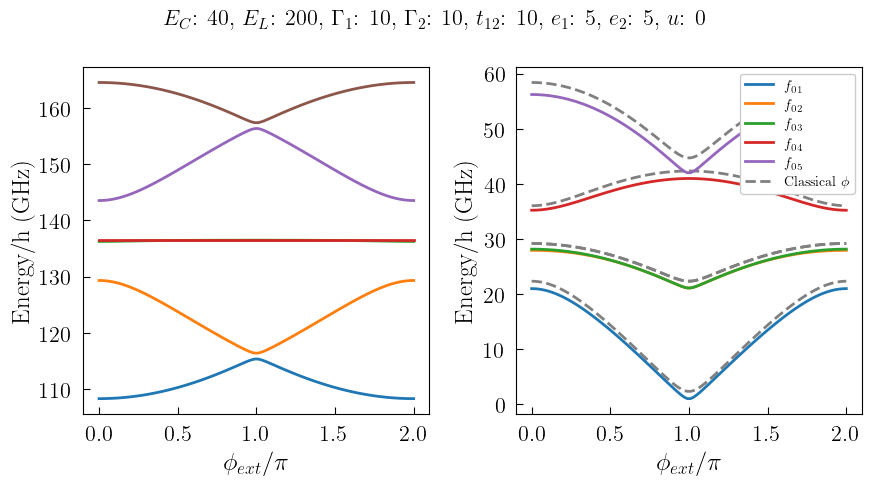

In [47]:
fig,ax = plt.subplots(1,2, figsize=(9,5))

title = rf'$E_C$: {Ec}, $E_L$: {El}, $\Gamma_1$: {Gamma1}, $\Gamma_2$: {Gamma2}, $t_{{12}}$: {t12}, $e_1$: {e1}, $e_2$: {e2}, $u$: {u}'
fig.suptitle(title)

ax[0].plot(phi_ext_array/np.pi,eigenstates)

for j in range(1, 6):  # Loop over final levels (i+1 to 5)
    transition_freq = eigenstates[:, j] - eigenstates[:, 0]
    label = rf'$f_{{0{j}}}$'  # Create label for the transition
    ax[1].plot(phi_ext_array/np.pi, transition_freq, label=label)
    
    clas_transition_freq = clas_eigvals_array[:, j] - clas_eigvals_array[:, 0]
    if j == 5:
        ax[1].plot(phi_ext_array/np.pi, clas_transition_freq, '--', color='gray', label=r'Classical $\phi$')
    else:
        ax[1].plot(phi_ext_array/np.pi, clas_transition_freq, '--', color='gray')


ax[0].set_xlabel(r'$\phi_{ext}/\pi$')
ax[1].set_xlabel(r'$\phi_{ext}/\pi$')
ax[0].set_ylabel(r'Energy/h (GHz)')
ax[1].set_ylabel(r'Energy/h (GHz)')
ax[1].legend(fontsize=10, loc='upper right')
fig.tight_layout()
plt.show()

Continuum model

In [287]:
def theoretical_excitations(epsilon, Delta, phi, lambda_1, lambda_2, tau, x_r, sign):
    if epsilon < -1*Delta or epsilon > 1*Delta:
        return 1e4
    else:
        return tau * np.cos((lambda_1 - lambda_2) * epsilon/Delta + sign * phi) + \
            (1 - tau) * np.cos((lambda_1 + lambda_2) * epsilon/Delta * x_r) - \
            np.cos(2 * np.arccos(epsilon/Delta) - (lambda_1 + lambda_2) * epsilon/Delta)


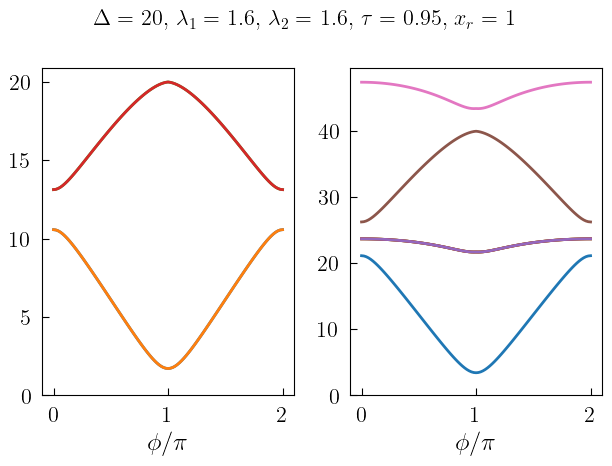

In [290]:
lambda_1 = lambda_2 = 1.6
tau, x_r =  0.95,1
Delta = 20
phi_values = np.linspace(0, 2 * np.pi, 101)
epsilon_0 = np.array([0.4*Delta, 0.8*Delta])
signs = [1,-1]

epsilon_array = np.zeros((len(phi_values),len(epsilon_0),2))

for i,phi in enumerate(phi_values):
    for j, e0 in enumerate(epsilon_0):
        for k, sign in enumerate(signs):
            epsilon_array[i,j,k] = fsolve(theoretical_excitations,e0,args=(Delta,phi,lambda_1, lambda_2, tau, x_r, sign))[0]

fig,ax = plt.subplots(1,2)

title = rf'$\Delta =$ {Delta}, $\lambda_1 = $ {lambda_1}, $\lambda_2 =$ {lambda_2}, $\tau =$ {tau}, $x_r = $ {x_r}'
fig.suptitle(title)


for i, e0 in enumerate(epsilon_0):
    ax[0].plot(phi_values/np.pi,epsilon_array[:,i,:])

ax[1].plot(phi_values/np.pi,(epsilon_array[:,0,0] + epsilon_array[:,0,1]))
ax[1].plot(phi_values/np.pi,(epsilon_array[:,0,0] + epsilon_array[:,1,0]))
ax[1].plot(phi_values/np.pi,(epsilon_array[:,0,0] + epsilon_array[:,1,1]))

ax[1].plot(phi_values/np.pi,(epsilon_array[:,0,1] + epsilon_array[:,1,0]))
ax[1].plot(phi_values/np.pi,(epsilon_array[:,0,1] + epsilon_array[:,1,1]))

ax[1].plot(phi_values/np.pi,(epsilon_array[:,1,0] + epsilon_array[:,1,1]))


ax[1].plot(phi_values/np.pi,(epsilon_array[:,0,0] + epsilon_array[:,0,1] + epsilon_array[:,1,0] + epsilon_array[:,1,1]))

ax[0].set_ylim(bottom=0)
ax[1].set_ylim(bottom=0)

ax[0].set_xlabel(r'$\phi/\pi$')
ax[1].set_xlabel(r'$\phi/\pi$')
fig.tight_layout()
plt.show()

Comparing QD model with Continuum model

In [294]:
import ipywidgets as widgets
from IPython.display import display

# Crear widgets para los parámetros
lambda_widget = widgets.FloatSlider(value=1.5, min=1, max=2, step=0.1, description=r'lambda')
tau_widget = widgets.FloatSlider(value=0.95, min=0, max=1, step=0.05, description=r'tau')
x_r_widget = widgets.FloatSlider(value=1, min=-1, max=1, step=0.1, description=r'x_r')
Delta_widget = widgets.FloatSlider(value=20, min=0, max=50, step=1, description=r'Delta')
Gamma1_widget = widgets.FloatSlider(value=10, min=0, max=20, step=1, description=r'Gamma_1')
Gamma2_widget = widgets.FloatSlider(value=10, min=0, max=20, step=1, description=r'Gamma_2')
t12_widget = widgets.FloatSlider(value=10, min=0, max=20, step=1, description=r't12')
e1_widget = widgets.FloatSlider(value=5, min=0, max=10, step=0.5, description=r'e_1')
e2_widget = widgets.FloatSlider(value=5, min=0, max=10, step=0.5, description=r'e_2')

grid = widgets.GridBox(children=[lambda_widget,tau_widget, x_r_widget, Delta_widget, Gamma1_widget, Gamma2_widget, t12_widget, e1_widget, e2_widget],
                       layout=widgets.Layout(grid_template_columns="repeat(3, 30%)"))

def update_plot(lambda0, tau, x_r, Delta, Gamma1, Gamma2, t12, e1, e2):

    lambda_1 = lambda_2 = lambda0
    # Delta = Gamma1 + Gamma2

    u = 0

    phi_values = np.linspace(0, 2 * np.pi, 101)

    # epsilon_0 = np.array([0.3*Delta, 0.9999*Delta])
    epsilon_0 = np.array([0.3*Delta, 0.85*Delta])
    signs = [1,-1]
    epsilon_array = np.zeros((len(phi_values),len(epsilon_0),2))

    clas_eigvals_array = np.zeros((len(phi_values), 6))

    for i,phi in enumerate(phi_values):

        #Quantum Dot model
        h = classical_hamiltonian(Gamma1, Gamma2, t12, e1,e2,u, phi)
        evals = h.eigenenergies()
        clas_eigvals_array[i] = evals

        # Continuum model
        for j, e0 in enumerate(epsilon_0):
            for k, sign in enumerate(signs):
                epsilon_array[i,j,k] = fsolve(theoretical_excitations,e0,args=(Delta,phi,lambda_1, lambda_2, tau, x_r, sign))[0]


    fig,ax = plt.subplots(1,2, figsize = (9,5))

    # title = rf'$\Delta =$ {Delta}, $\lambda_1 = $ {lambda_1}, $\lambda_2 =$ {lambda_2}, $\tau =$ {tau}, $x_r = $ {x_r}'
    title = (rf'$\Delta =$ {Delta}, $\lambda_1 = $ {lambda_1}, $\lambda_2 =$ {lambda_2}, $\tau =$ {tau}, $x_r = $ {x_r}'
            f'\n $\\Gamma_1 =$ {Gamma1}, $\Gamma_2 = $ {Gamma2}, $t_{{12}} = $ {t12}, $e_1 = $ {e1}, $e_2 = $ {e2}, $u = $ {u}')
    fig.suptitle(title)

    for i, e0 in enumerate(epsilon_0):
        for k, sign in enumerate(signs):
            ax[0].plot(phi_values/np.pi,epsilon_array[:,i,k])

    ax[1].plot(phi_values/np.pi,(epsilon_array[:,0,0] + epsilon_array[:,0,1]))
    ax[1].plot(phi_values/np.pi,(epsilon_array[:,0,0] + epsilon_array[:,1,0]))
    ax[1].plot(phi_values/np.pi,(epsilon_array[:,0,0] + epsilon_array[:,1,1]))
    ax[1].plot(phi_values/np.pi,(epsilon_array[:,0,1] + epsilon_array[:,1,0]))
    ax[1].plot(phi_values/np.pi,(epsilon_array[:,0,1] + epsilon_array[:,1,1]))
    ax[1].plot(phi_values/np.pi,(epsilon_array[:,1,0] + epsilon_array[:,1,1]))
    ax[1].plot(phi_values/np.pi,(epsilon_array[:,0,0] + epsilon_array[:,0,1] + epsilon_array[:,1,0] + epsilon_array[:,1,1]))

    for j in range(1, 6):  # Loop over final levels (i+1 to 5)
        transition_freq = clas_eigvals_array[:, j] - clas_eigvals_array[:, 0]
        label = rf'$f_{{0{j}}}$'  # Create label for the transition
        ax[1].plot(phi_values/np.pi, transition_freq, label='QD', linestyle='--',color = 'black')

    ax[0].set_ylim(bottom=0)
    ax[1].set_ylim(bottom=0)
    ax[1].set_ylim(top=70)

    ax[0].set_xlabel(r'$\phi/\pi$')
    ax[1].set_xlabel(r'$\phi/\pi$')
    fig.tight_layout()
    plt.show()

# Interactuar con la función y los widgets
widgets.interact(update_plot,
                 lambda0=lambda_widget,
                 tau=tau_widget,
                 x_r=x_r_widget,
                 Delta=Delta_widget,
                 Gamma1=Gamma1_widget,
                 Gamma2=Gamma2_widget,
                 t12=t12_widget,
                 e1=e1_widget,
                 e2=e2_widget)

display(grid)


interactive(children=(FloatSlider(value=1.5, description='lambda', max=2.0, min=1.0), FloatSlider(value=0.95, …

GridBox(children=(FloatSlider(value=1.5, description='lambda', max=2.0, min=1.0), FloatSlider(value=0.95, desc…

Automated fit

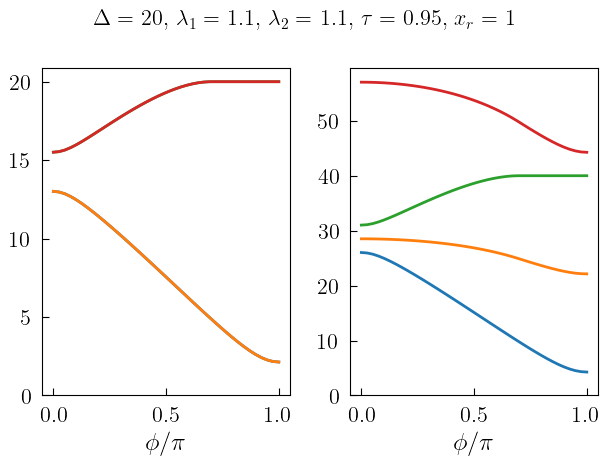

In [301]:
Delta = 20
lambda_1 = lambda_2 = 1.1
tau, x_r =  0.95,1
phi_values = np.linspace(0, np.pi, 40)
epsilon_0 = np.array([0.4*Delta, 0.8*Delta])
signs = [1,-1]

epsilon_array = np.zeros((len(phi_values),len(epsilon_0),2))

for i,phi in enumerate(phi_values):
    for j, e0 in enumerate(epsilon_0):
        for k, sign in enumerate(signs):
            epsilon_array[i,j,k] = fsolve(theoretical_excitations,e0,args=(Delta,phi,lambda_1, lambda_2, tau, x_r, sign))[0]

transition1 = epsilon_array[:,0,0] + epsilon_array[:,0,1]
transition2 = epsilon_array[:,0,1] + epsilon_array[:,1,0]
transition3 = epsilon_array[:,1,0] + epsilon_array[:,1,1]
transition4 = epsilon_array[:,0,0] + epsilon_array[:,0,1] + epsilon_array[:,1,0] + epsilon_array[:,1,1]

fig,ax = plt.subplots(1,2)

title = rf'$\Delta =$ {Delta}, $\lambda_1 = $ {lambda_1}, $\lambda_2 =$ {lambda_2}, $\tau =$ {tau}, $x_r = $ {x_r}'
fig.suptitle(title)


for i, e0 in enumerate(epsilon_0):
    ax[0].plot(phi_values/np.pi,epsilon_array[:,i,:])

ax[1].plot(phi_values/np.pi,transition1)
ax[1].plot(phi_values/np.pi,transition2)
ax[1].plot(phi_values/np.pi,transition3)
ax[1].plot(phi_values/np.pi,transition4)

ax[0].set_ylim(bottom=0)
ax[1].set_ylim(bottom=0)

ax[0].set_xlabel(r'$\phi/\pi$')
ax[1].set_xlabel(r'$\phi/\pi$')
fig.tight_layout()
plt.show()

In [302]:
transitions_continuum = np.stack([transition1,transition2, transition3, transition4]).T

In [303]:
def transitions_qd(params):
    Gamma1, Gamma2, t12, e1, e2 = params
    levels_to_fit = 4

    # Quantum dot model to fit
    u = 0
    matrix = np.array([
        [0, 0,      0,       0,         0,                    0],
        [0, 2*e1+u, t12,    -t12,       0,                    0],
        [0, 0,      e1 + e2, 0,         t12,                  0],
        [0, 0,      0,       e1 + e2,  -t12,                  0],
        [0, 0,      0,       0,         2*e2 + u,             0],
        [0, 0,      0,       0,         0,          2*(e1+e2+u)],
    ], dtype=complex)

    phi_values = np.linspace(0, np.pi, 40)
    transitions_array = np.zeros((len(phi_values),4))
    for i,phi in enumerate(phi_values):
        matrix[0,1] = matrix[4,5] = Gamma1*np.exp(-1j*phi/2)
        matrix[0,4] = matrix[1,5] = Gamma2*np.exp(1j*phi/2)
        upper_tri = np.triu(matrix)
        ind_matrix = upper_tri + upper_tri.T.conjugate() - np.diag(np.diag(matrix))
        evals = np.linalg.eigvalsh(ind_matrix)
        transitions = evals[[1,2,4,5]] - evals[0]
        transitions_array[i] = transitions

    transitions_array = transitions_array[:,:levels_to_fit]
    return transitions_array

In [304]:
def cost_function(params):
    transitions_array = transitions_qd(params)
    cost = np.sqrt(np.sum((transitions_array - transitions_continuum[:,:4])**2))
    return cost


arg_init = [8,8,10,3,1]
resultado = minimize(cost_function, arg_init)


In [305]:
resultado

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.597135341804415
        x: [ 9.137e+00  9.132e+00  1.097e+01  2.926e+00  1.042e+00]
      nit: 11
      jac: [-1.192e-06  3.576e-07 -2.980e-07  5.960e-08  1.490e-06]
 hess_inv: [[ 5.344e-01 -4.269e-01 ...  4.275e-02 -1.458e-01]
            [-4.269e-01  5.958e-01 ...  7.778e-02 -7.125e-02]
            ...
            [ 4.275e-02  7.778e-02 ...  6.235e-01 -3.090e-01]
            [-1.458e-01 -7.125e-02 ... -3.090e-01  5.648e-01]]
     nfev: 96
     njev: 16

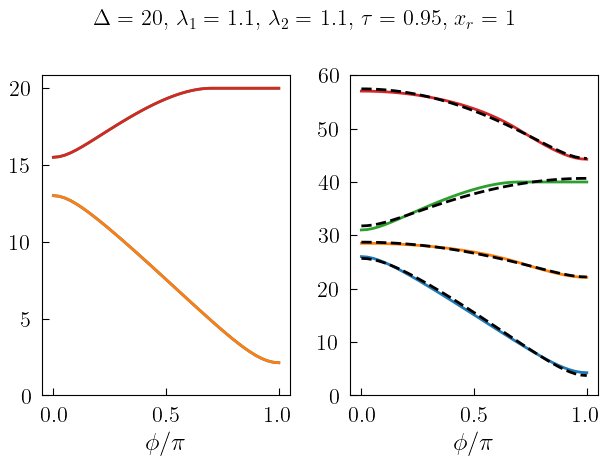

In [306]:
phi_values = np.linspace(0, np.pi, 40)
epsilon_0 = np.array([0.4*Delta, 0.8*Delta])
signs = [1,-1]

epsilon_array = np.zeros((len(phi_values),len(epsilon_0),2))

for i,phi in enumerate(phi_values):
    for j, e0 in enumerate(epsilon_0):
        for k, sign in enumerate(signs):
            epsilon_array[i,j,k] = fsolve(theoretical_excitations,e0,args=(Delta,phi,lambda_1, lambda_2, tau, x_r, sign))[0]

transition1 = epsilon_array[:,0,0] + epsilon_array[:,0,1]
transition2 = epsilon_array[:,0,1] + epsilon_array[:,1,0]
transition3 = epsilon_array[:,1,0] + epsilon_array[:,1,1]
transition4 = epsilon_array[:,0,0] + epsilon_array[:,0,1] + epsilon_array[:,1,0] + epsilon_array[:,1,1]

fig,ax = plt.subplots(1,2)

title = rf'$\Delta =$ {Delta}, $\lambda_1 = $ {lambda_1}, $\lambda_2 =$ {lambda_2}, $\tau =$ {tau}, $x_r = $ {x_r}'
fig.suptitle(title)


for i, e0 in enumerate(epsilon_0):
    ax[0].plot(phi_values/np.pi,epsilon_array[:,i,:])

ax[1].plot(phi_values/np.pi,transition1)
ax[1].plot(phi_values/np.pi,transition2)
ax[1].plot(phi_values/np.pi,transition3)
ax[1].plot(phi_values/np.pi,transition4)

ax[1].plot(phi_values/np.pi,transitions_qd(resultado.x),'--', color='black')
ax[0].set_ylim(bottom=0)
ax[1].set_ylim(bottom=0)

ax[0].set_xlabel(r'$\phi/\pi$')
ax[1].set_xlabel(r'$\phi/\pi$')
fig.tight_layout()
plt.show()

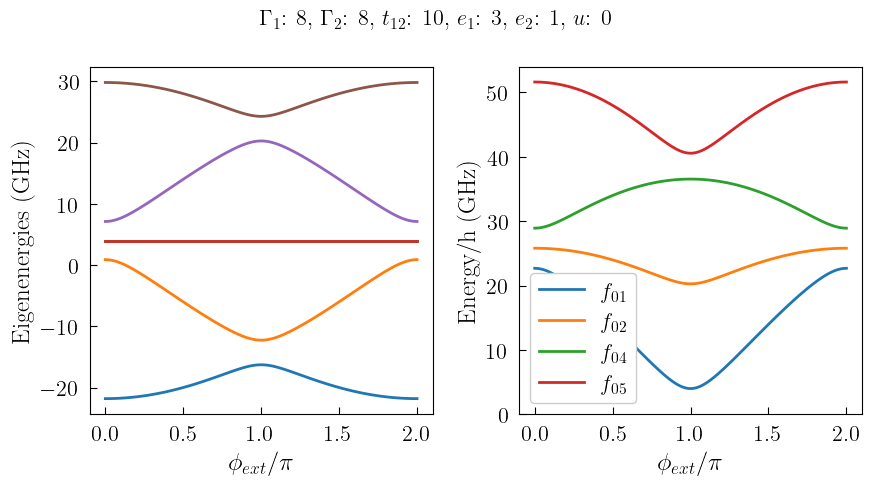

In [194]:
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(9, 5))

title = rf'$\Gamma_1$: {Gamma1}, $\Gamma_2$: {Gamma2}, $t_{{12}}$: {t12}, $e_1$: {e1}, $e_2$: {e2}, $u$: {u}'
        
fig.suptitle(title)

# Plot eigenenergies
ax[0].plot(clas_phase_array/np.pi, clas_eigvals_array)
ax[0].set_xlabel(r'$\phi_{ext}/\pi$')
ax[0].set_ylabel(r'Eigenenergies (GHz)')

# Plot all transitions
for j in [1,2,4,5]:  # Loop over final levels (i+1 to 5)
    transition_freq = clas_eigvals_array[:, j] - clas_eigvals_array[:, 0]
    label = rf'$f_{{0{j}}}$'  # Create label for the transition
    ax[1].plot(clas_phase_array/np.pi, transition_freq, label=label)

ax[1].plot(clas_eigvals_array/np)
ax[1].set_xlabel(r'$\phi_{ext}/\pi$')
ax[1].set_ylim(bottom = 0)
ax[1].set_ylabel(r'Energy/h (GHz)')
ax[1].legend()
fig.tight_layout()
plt.show()


Cleaning stuffs

In [363]:
def qd_model_transitions(params,phase_array):
    Gamma1, Gamma2, t12, e1, e2 = params
    u = 0

    matrix = np.array([
        [0, 0,      0,       0,         0,                    0],
        [0, 2*e1+u, t12,    -t12,       0,                    0],
        [0, 0,      e1 + e2, 0,         t12,                  0],
        [0, 0,      0,       e1 + e2,  -t12,                  0],
        [0, 0,      0,       0,         2*e2 + u,             0],
        [0, 0,      0,       0,         0,          2*(e1+e2+u)],
    ], dtype=complex)

    transitions_array = np.zeros((len(phase_array),4))
    for i,phi in enumerate(phase_array):
        matrix[0,1] = matrix[4,5] = Gamma1*np.exp(-1j*phi/2)
        matrix[0,4] = matrix[1,5] = Gamma2*np.exp(1j*phi/2)
        upper_tri = np.triu(matrix)
        ind_matrix = upper_tri + upper_tri.T.conjugate() - np.diag(np.diag(matrix))
        evals = np.linalg.eigvalsh(ind_matrix)
        transitions = evals[[1,2,4,5]] - evals[0]
        transitions_array[i] = transitions

    return transitions_array

def continuum_model_eigvals(params,phase_array):
    Delta,lambda_1,lambda_2,tau,x_r  = params    
    epsilon_0 = np.array([0.4*Delta, 0.8*Delta])
    signs = [1,-1]

    epsilon_array = np.zeros((len(phase_array),len(epsilon_0),len(signs)))

    for i,phi in enumerate(phase_array):
        for j, e0 in enumerate(epsilon_0):
            for k, sign in enumerate(signs):
                epsilon_array[i,j,k] = fsolve(theoretical_excitations,e0,args=(Delta,phi,lambda_1, lambda_2, tau, x_r, sign))[0]

    return epsilon_array

def continuum_model_transitions(params,phase_array):
    epsilon_array = continuum_model_eigvals(params,phase_array)
    
    transition1 = epsilon_array[:,0,0] + epsilon_array[:,0,1]
    transition2 = epsilon_array[:,0,1] + epsilon_array[:,1,0]
    transition3 = epsilon_array[:,1,0] + epsilon_array[:,1,1]
    transition4 = epsilon_array[:,0,0] + epsilon_array[:,0,1] + epsilon_array[:,1,0] + epsilon_array[:,1,1]

    transitions_continuum = np.stack([transition1,transition2, transition3, transition4]).T

    return transitions_continuum

def make_cost_function(FIXED_PARAMS):
    """Crea una función de costo para un conjunto específico de parámetros fijos."""
    def cost_function(params):
        phase_array = np.linspace(0, np.pi, 40)
        transitions_continuum = continuum_model_transitions(FIXED_PARAMS, phase_array)
        transitions_array = qd_model_transitions(params, phase_array)
        cost = np.sqrt(np.sum((transitions_array - transitions_continuum)**2))
        return cost
    return cost_function

In [382]:
lambda0 = 1.9
FIXED_PARAMS = 40, lambda0, lambda0, 0.95, 1
cost_function = make_cost_function(FIXED_PARAMS)
arg_init = [20,20,20,3,1]
resultado = minimize(cost_function, arg_init)

In [383]:
resultado

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 51.38809561975494
        x: [ 1.796e+01  1.616e+01  1.390e+01  9.102e+00  6.304e+00]
      nit: 13
      jac: [ 3.338e-06  9.537e-07  2.861e-06  9.537e-07  2.861e-06]
 hess_inv: [[ 6.154e-01 -2.933e-01 ... -3.232e-01 -1.876e-01]
            [-2.933e-01  9.722e-01 ... -7.220e-01 -5.548e-01]
            ...
            [-3.232e-01 -7.220e-01 ...  2.167e+00  1.108e+00]
            [-1.876e-01 -5.548e-01 ...  1.108e+00  2.007e+00]]
     nfev: 102
     njev: 17

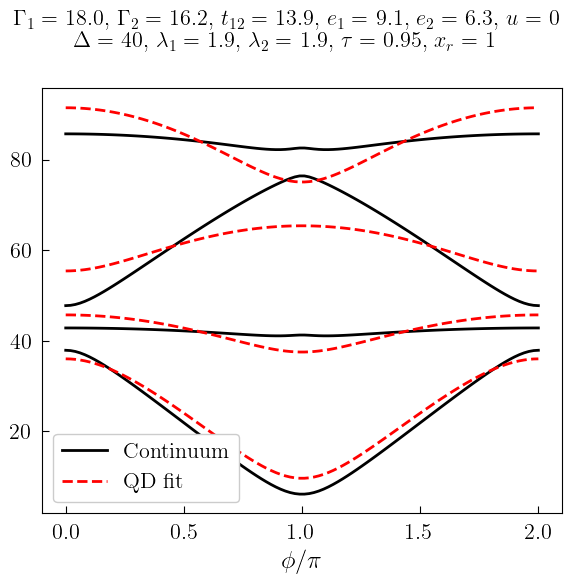

In [384]:
Gamma1, Gamma2, t12, e1, e2 = np.round(resultado.x,1)
Delta,lambda_1,lambda_2,tau,x_r  = FIXED_PARAMS
phase_array = np.linspace(0,2*np.pi,100)
from matplotlib.lines import Line2D

fig,ax = plt.subplots(1,1, figsize=(6,6))
title = rf'$\Gamma_1=$ {Gamma1}, $\Gamma_2=$ {Gamma2}, $t_{{12}}=$ {t12}, $e_1=$ {e1}, $e_2=$ {e2}, $u=$ {0}'f'\n $\Delta =$ {Delta}, $\lambda_1 = $ {lambda_1}, $\lambda_2 =$ {lambda_2}, $\\tau =$ {tau}, $x_r = $ {x_r}'

fig.suptitle(title)

ax.plot(phase_array/np.pi, continuum_model_transitions(FIXED_PARAMS,phase_array), color='black', label = 'Continuum')
ax.plot(phase_array/np.pi, qd_model_transitions(resultado.x,phase_array),'--', color='red', label = 'QD fit')

legend_elements = [Line2D([0], [0], color='black', lw=2, label='Continuum'),
                   Line2D([0], [0], color='red', lw=2, ls='--', label='QD fit')]

# Crea la leyenda con los elementos definidos
ax.legend(handles=legend_elements, loc='lower left')
ax.set_xlabel(r'$\phi/\pi$')
fig.tight_layout()
plt.show()